# SST Demo: Machine Learning Prediction of ENSO from SST

This notebook demonstrates the SST package for machine learning prediction of ENSO from Sea Surface Temperature data. It will:

1. Import the SST package modules.
2. Run the ML prediction workflow using Python functions on the sample CSVs in `data/`.
3. Load and explore the resulting ML artifacts (predictions, feature importance).
4. Visualize the model performance and feature importance.

**Command to install dependencies:**

`%pip install -e ".[dev]"`

> **Tip:** Make sure your working directory is the repo root (where `pyproject.toml` lives)
> when you install the dependencies to run. This uses the `pyproject.toml` in the repo and installs the `sst` CLI and Python package into your current environment.

In [1]:
# Environment checks
import sys
from pathlib import Path

# Get the repo root (parent of docs directory)
root = Path.cwd().parent
print("Python:", sys.version)
print("Working directory:", root)
print("Contents here:", [p.name for p in root.iterdir()])

Python: 3.13.9 (main, Oct 17 2025, 11:40:15) [Clang 16.0.0 (clang-1600.0.26.6)]
Working directory: /Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst
Contents here: ['.flake8', 'artifacts', 'mkdocs.yml', 'LICENSE', '.pytest_cache', '.pre-commit-config.yaml', 'Dockerfile', 'CITATION.cff', '.ruff_cache', 'pyproject.toml', 'tests', 'docs', 'README.md', '.dockerignore', '.mypy_cache', '.gitignore', '.venv', 'scripts', '.github', 'site', '.git', 'data', 'src']


# 1. Run the ML prediction workflow using the Python package

This imports the SST package modules and runs the ML prediction workflow directly,
writing artifacts into an `artifacts/` directory in the repo root.

In [ ]:
# Import the SST package modules
from pathlib import Path

from sst.io import load_enso, load_sst
from sst.ml import predict_enso_from_sst
from sst.plot import make_ml_prediction_plot
from sst.transform import join_on_month, tidy

# Set up paths
root = Path.cwd().parent
sst_path = root / "data" / "sst_sample.csv"
enso_path = root / "data" / "nino34_sample.csv"
out_dir = root / "artifacts"
out_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory for model artifacts: {out_dir}")

Output directory for model artifacts: /Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts


In [3]:
# Run the ML prediction workflow
print("Loading SST data...")
sst_df = tidy(load_sst(sst_path), date_col="date", value_col="sst_c", roll=12)

print("Loading ENSO data...")
enso_df = tidy(load_enso(enso_path), date_col="date", value_col="nino34", roll=12)

print("Joining datasets...")
joined = join_on_month(sst_df, enso_df, start="2000-01")

print("Training ML model to predict ENSO from SST...")
results = predict_enso_from_sst(
    joined,
    n_lags=3,
    test_size=0.2,
    random_state=42,
    model_path=out_dir / "model.joblib",
)

print(f"Model performance: R² = {results['r2_score']:.3f}, RMSE = {results['rmse']:.3f}")

Loading SST data...
Loading ENSO data...
Joining datasets...
Training ML model to predict ENSO from SST...
Model performance: R² = 0.973, RMSE = 0.067


✓ Wrote /Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts/ml_predictions.csv
✓ Wrote /Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts/ml_feature_importance.csv
✓ Wrote /Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts/ml_predictions.png

Artifacts directory now contains:
[PosixPath('/Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts/summary.csv'), PosixPath('/Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts/scatter_plot.png'), PosixPath('/Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts/ml_predictions.csv'), PosixPath('/Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts/model.joblib'), PosixPath('/Users/ntebaldi/Documents/ai+science/workshops/workshop_1_github_actions/sst/artifacts/ml_feature_importance.csv'), PosixPath('/Users/nteba

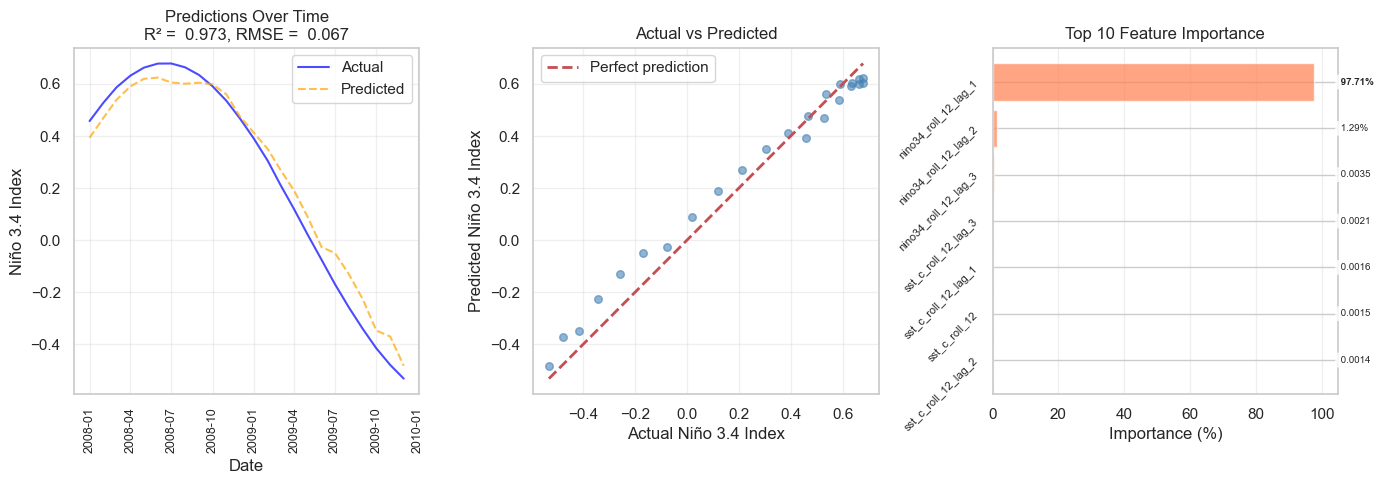

In [4]:
# Save predictions CSV
predictions_path = out_dir / "ml_predictions.csv"
results["predictions"].to_csv(predictions_path, index=False)
print(f"✓ Wrote {predictions_path}")

# Save feature importance CSV
importance_path = out_dir / "ml_feature_importance.csv"
results["feature_importance"].to_csv(importance_path, index=False)
print(f"✓ Wrote {importance_path}")

# Save ML prediction plot
fig = make_ml_prediction_plot(results)
plot_path = out_dir / "ml_predictions.png"
fig.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"✓ Wrote {plot_path}")

print(f"\nArtifacts directory now contains:\n{list(out_dir.iterdir())}")

## 2. Explore the raw sample CSVs

We will load the SST and ENSO (Niño 3.4) sample CSVs from `data/` and
inspect their structure. The code below intentionally treats the first
column as a date/time index and any remaining columns as numeric values,
so it will stay robust even if column names are tweaked in the future.

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

root = Path.cwd().parent


def load_time_series(path: Path) -> pd.DataFrame:
    """Generic helper: parse first column as datetime and set as index."""
    df = pd.read_csv(path, parse_dates=[0])
    df = df.set_index(df.columns[0]).sort_index()
    return df


sst_raw = load_time_series(root / "data" / "sst_sample.csv")
enso_raw = load_time_series(root / "data" / "nino34_sample.csv")

display("SST sample:")
display(sst_raw.head())

display("ENSO (Niño 3.4) sample:")
display(enso_raw.head())

'SST sample:'

,sst_c
date,
2000-01-01,20.000
2000-02-01,20.601
2000-03-01,21.041
2000-04-01,21.202
2000-05-01,21.043


'ENSO (Niño 3.4) sample:'

,nino34
date,
2000-01-01,0.000
2000-02-01,0.145
2000-03-01,0.288
2000-04-01,0.424
2000-05-01,0.551


### Plot the raw time series

We plot all numeric columns from each dataset against their datetime index.

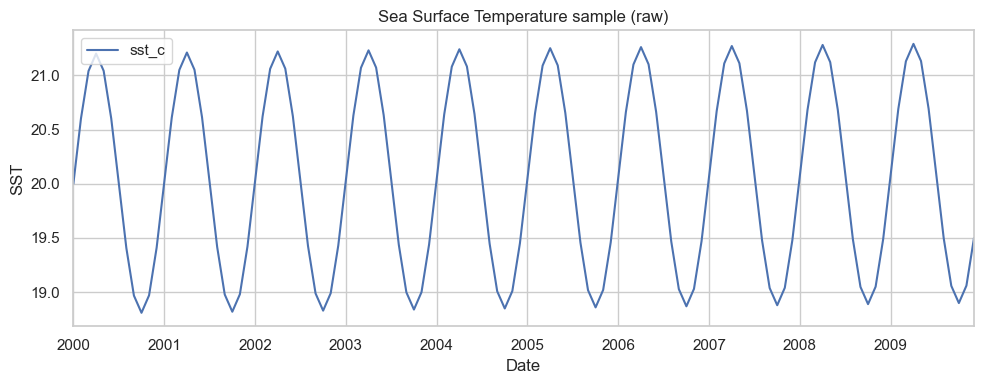

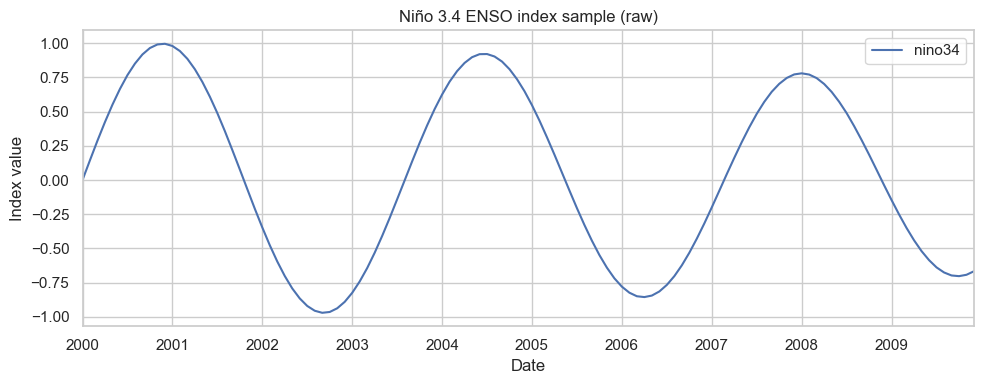

In [6]:
plt.figure(figsize=(10, 4))
sst_raw.select_dtypes("number").plot(ax=plt.gca())
plt.title("Sea Surface Temperature sample (raw)")
plt.xlabel("Date")
plt.ylabel("SST")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
enso_raw.select_dtypes("number").plot(ax=plt.gca())
plt.title("Niño 3.4 ENSO index sample (raw)")
plt.xlabel("Date")
plt.ylabel("Index value")
plt.tight_layout()
plt.show()

## 3. Inspect and explore the ML prediction artifacts

After running the ML prediction workflow, you should have several artifacts
in `artifacts/`. We will load and explore the predictions and feature importance.

In [7]:
root = Path.cwd().parent
artifacts = root / "artifacts"

# Load the predictions CSV
predictions_path = artifacts / "ml_predictions.csv"
predictions = pd.read_csv(predictions_path, parse_dates=["date"])
display("ML Predictions (first few rows):")
display(predictions.head())

'ML Predictions (first few rows):'

,date,actual,predicted,residual
0,2008-01-01,0.457417,0.393394,0.064023
1,2008-02-01,0.528250,0.470006,0.058244
2,2008-03-01,0.586750,0.539111,0.047639
3,2008-04-01,0.631750,0.590405,0.041345
4,2008-05-01,0.662333,0.619597,0.042737


In [8]:
# Load the feature importance CSV
importance_path = artifacts / "ml_feature_importance.csv"
importance = pd.read_csv(importance_path)
display("Feature Importance:")
display(importance)

'Feature Importance:'

,feature,importance
0,nino34_roll_12_lag_1,0.977148
1,nino34_roll_12_lag_2,0.012872
2,nino34_roll_12_lag_3,0.003466
3,sst_c_roll_12_lag_3,0.002054
4,sst_c_roll_12_lag_1,0.001556
5,sst_c_roll_12,0.001527
6,sst_c_roll_12_lag_2,0.001377


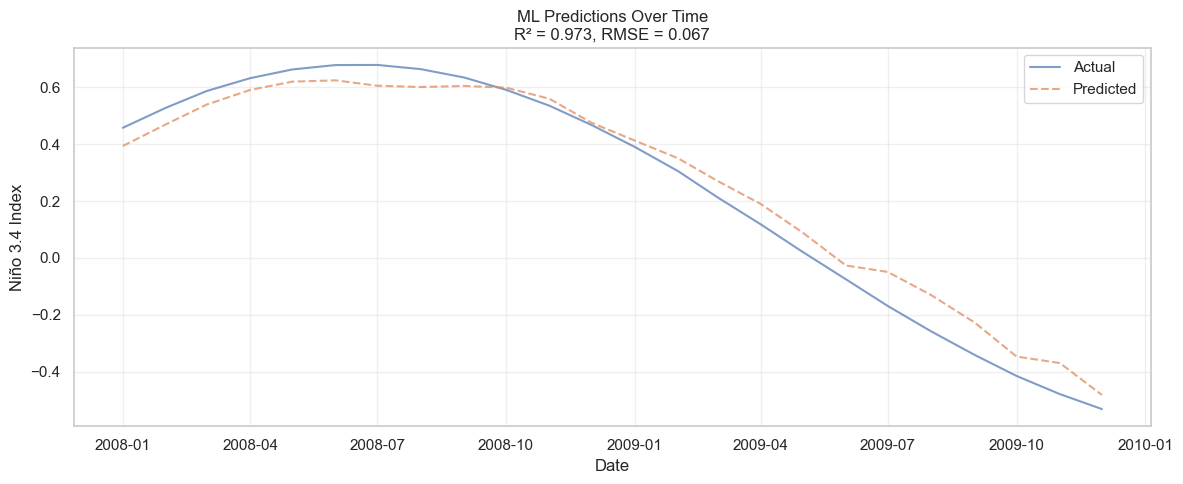

In [ ]:
# Calculate R² and RMSE from predictions for the plot title
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(predictions["actual"], predictions["predicted"])
rmse = np.sqrt(mean_squared_error(predictions["actual"], predictions["predicted"]))

# Plot predictions over time
plt.figure(figsize=(12, 5))
plt.plot(predictions["date"], predictions["actual"], label="Actual", alpha=0.7, linewidth=1.5)
plt.plot(
    predictions["date"],
    predictions["predicted"],
    label="Predicted",
    alpha=0.7,
    linewidth=1.5,
    linestyle="--",
)
plt.xlabel("Date")
plt.ylabel("Niño 3.4 Index")
plt.title(f"ML Predictions Over Time\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

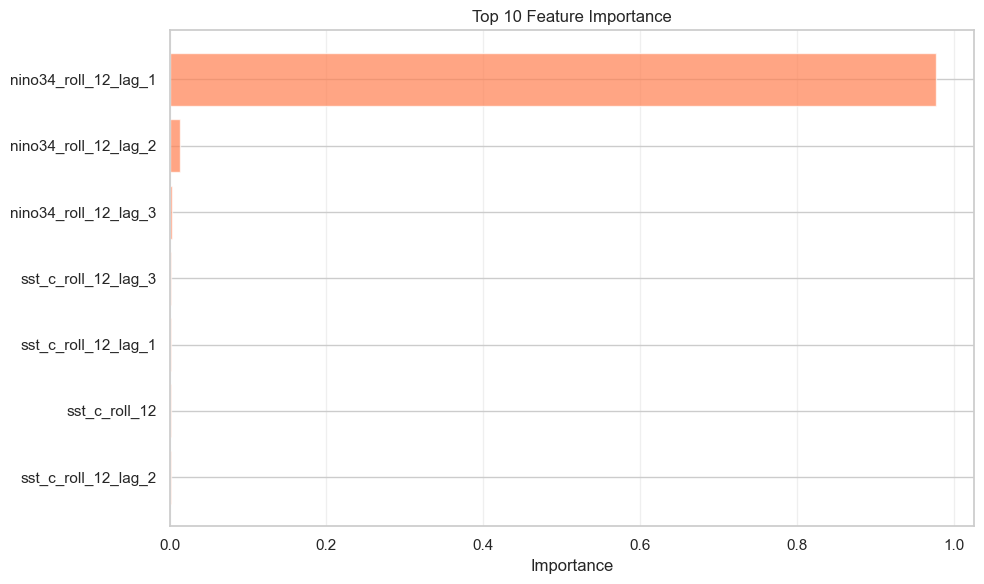

In [10]:
# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = importance.head(10)
plt.barh(range(len(top_features)), top_features["importance"], color="coral", alpha=0.7)
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importance")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

## 4. (Optional) Display the generated ML prediction figure

The workflow also writes a `ml_predictions.png` figure into `artifacts/`. If it
exists, we can display it inline as a quick visual check.

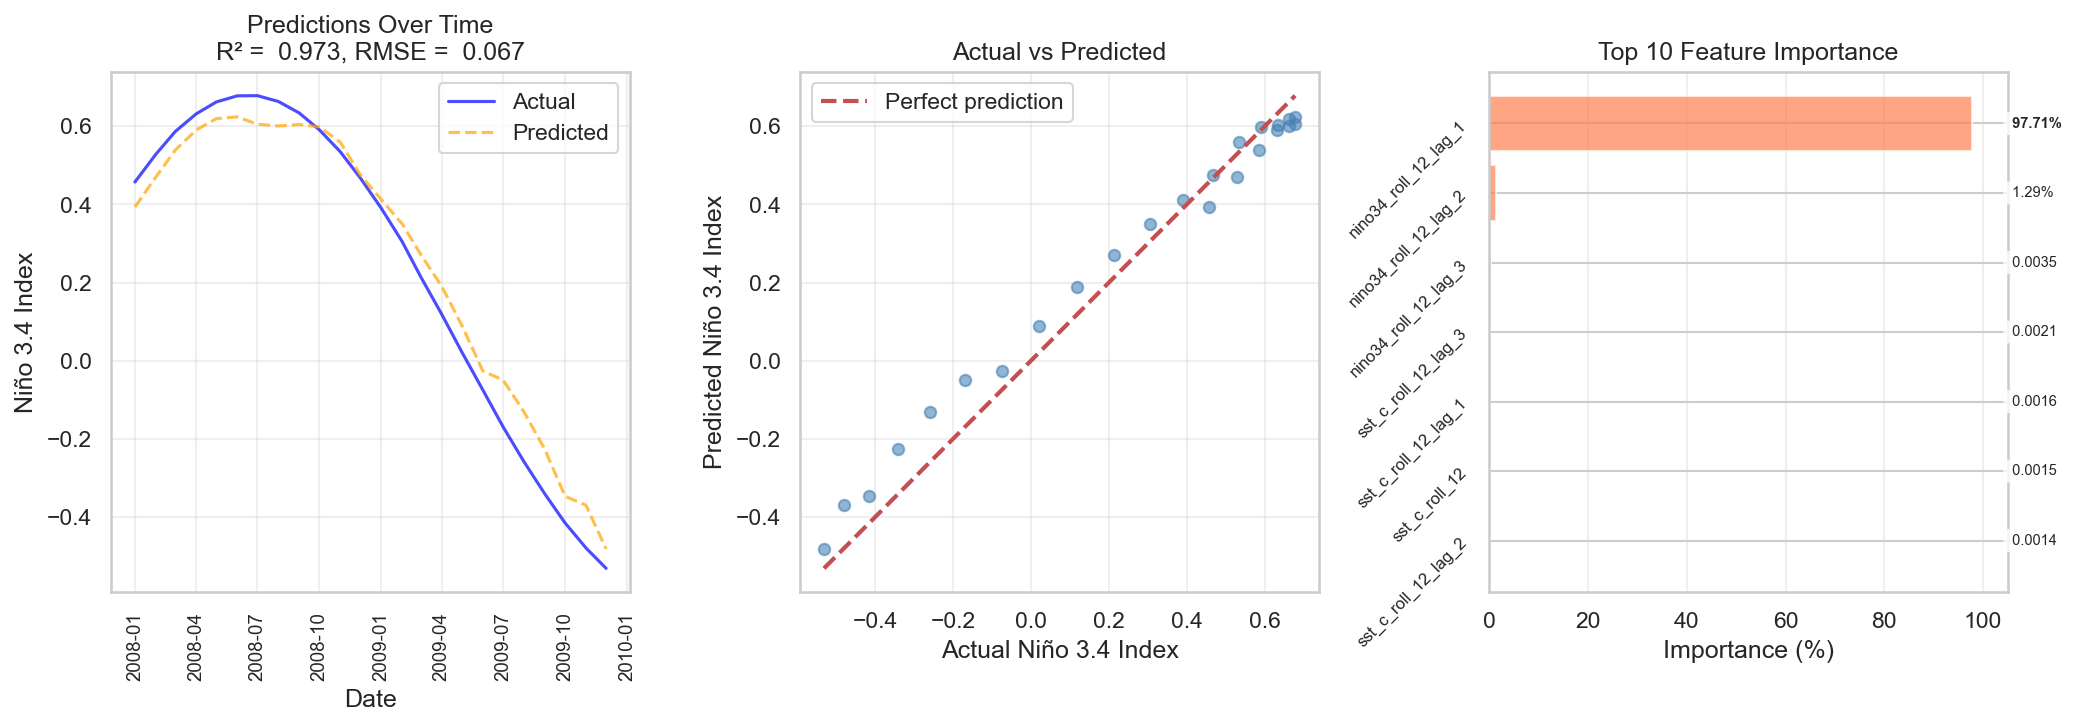

In [11]:
root = Path.cwd().parent
artifacts = root / "artifacts"
ml_plot_path = artifacts / "ml_predictions.png"

if ml_plot_path.exists():
    from IPython.display import Image, display

    display(Image(filename=str(ml_plot_path)))
else:
    print("No ml_predictions.png found in artifacts/")